# Inferential statistics and machine learning

here we will use robust statistics for correlation and for most highly correlated we will try and see size of effect. Need to use a form of Cohen's D that copes with non normality

- also need to remember we haven't done any analysis of exclusions, looked after children and mental health yet

Our seaborn plots were very much influenced by https://towardsdatascience.com/analyzing-data-distributions-with-seaborn-a8607961a212

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import altair as alt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
import numpy as np

### Load socioeconomic data

In [2]:
london_features = pd.read_csv("./DataSources/Income and Deprivation/socio_economic_features.csv")
print(london_features.shape)
london_features.head()

(4835, 27)


lsoa_code                  lsoa_name   lad_code              lad_name  \
0  E01000001        City of London 001A  E09000001        City of London   
1  E01000002        City of London 001B  E09000001        City of London   
2  E01000003        City of London 001C  E09000001        City of London   
3  E01000005        City of London 001E  E09000001        City of London   
4  E01000006  Barking and Dagenham 016A  E09000002  Barking and Dagenham   

   income_deprivation_score  employment_deprivation_score  \
0                     0.007                         0.010   
1                     0.034                         0.027   
2                     0.086                         0.086   
3                     0.211                         0.136   
4                     0.117                         0.059   

   child_income_deprivation_score  lone_parent_pct  ethnic_white_pct  \
0                           0.006         0.026256          0.845051   
1                           0.037         0.026506          0.887187   
2                           0.052         0.059976          0.783804   
3                           0.209         0.094218          0.513706   
4                           0.155         0.099448          0.327070   

   ethnic_mixed_pct  ...  no_qualifications_pct  degree_educated_pct  \
0          0.036860  ...                  0.019                0.776   
1          0.037604  ...                  0.023                0.792   
2          0.040862  ...                  0.130                0.568   
3          0.059898  ...                  0.244                0.345   
4          0.034058  ...                  0.182                0.329   

   population_density  median_house_price  log_rent_social_pct  \
0            0.140067            0.132214            -3.057608   
1            0.077879            0.157300            -2.847312   
2            0.284826            0.082149            -1.018877   
3            0.075522            0.066430            -0.403467   
4            0.144255            0.034776            -3.411248   

   log_ethnic_other_pct  log_population_density  log_median_house_price  \
0             -3.763250               -1.965633               -2.023336   
1             -5.072392               -2.552593               -1.849602   
2             -4.069398               -1.255877               -2.499220   
3             -3.064000               -2.583326               -2.711609   
4             -3.528124               -1.936171               -3.358826   

   log_ethnic_black_pct  log_ethnic_asian_pct  
0             -4.891715             -2.437580  
1             -5.883322             -2.715740  
2             -3.398230             -2.080929  
3             -2.287471             -1.279514  
4             -2.263997             -0.682052  

[5 rows x 27 columns]



### Load and merge crime data
We remember from our crime analysis that if we bound our distribution to LSOAs where the crime_per_1000 is between 1.35 and 62.1 (which are the upper and lower fences in the boxplot), we remove the extreme outliers and the remaining distribution is more close to normal. Doing so only removes 252 of 4,829 observations (LSOAs), which is around 4.5% of our overall distribution. This will be our strategy for the inferential statistics

In [3]:
london_crimes = pd.read_csv("./DataSources/Crime and outcomes/violent_crimes.csv")
crimes_subset = london_crimes[(london_crimes.crime_per_1000 < 62.1) & (london_crimes.crime_per_1000 > 1.35)].copy()
print(crimes_subset.shape)
crimes_subset.head()

(4577, 9)


lsoa_code               borough  ldn_datastore_total  police_total  \
0  E01000006  Barking and Dagenham                   55          50.0   
2  E01000008  Barking and Dagenham                   54          89.0   
3  E01000009  Barking and Dagenham                   96         115.0   
5  E01000011  Barking and Dagenham                   42          49.0   
6  E01000012  Barking and Dagenham                   69          54.0   

   LSOA Code                  lsoa_name  population  crime_per_1000  \
0  E01000006  Barking and Dagenham 016A        2094       23.877746   
2  E01000008  Barking and Dagenham 015B        1597       55.729493   
3  E01000009  Barking and Dagenham 016B        1929       59.616382   
5  E01000011  Barking and Dagenham 016C        1726       28.389340   
6  E01000012  Barking and Dagenham 015D        2343       23.047375   

   crime_per_1000_proportion  
0                   0.175380  
2                   0.409329  
3                   0.437878  
5                   0.208518  
6                   0.169281

In [4]:
violence_socio_economic = pd.merge(crimes_subset, london_features, left_on='lsoa_code', 
                            right_on='lsoa_code', how = 'inner')

violence_socio_economic.rename(columns = {'lsoa_name_x':'lsoa_name'}, inplace = True)
violence_socio_economic.drop('lsoa_name_y', axis=1, inplace=True)
violence_socio_economic.drop('LSOA Code', axis=1, inplace=True)

print(violence_socio_economic.shape)
violence_socio_economic.head()

(4577, 33)


lsoa_code               borough  ldn_datastore_total  police_total  \
0  E01000006  Barking and Dagenham                   55          50.0   
1  E01000008  Barking and Dagenham                   54          89.0   
2  E01000009  Barking and Dagenham                   96         115.0   
3  E01000011  Barking and Dagenham                   42          49.0   
4  E01000012  Barking and Dagenham                   69          54.0   

                   lsoa_name  population  crime_per_1000  \
0  Barking and Dagenham 016A        2094       23.877746   
1  Barking and Dagenham 015B        1597       55.729493   
2  Barking and Dagenham 016B        1929       59.616382   
3  Barking and Dagenham 016C        1726       28.389340   
4  Barking and Dagenham 015D        2343       23.047375   

   crime_per_1000_proportion   lad_code              lad_name  ...  \
0                   0.175380  E09000002  Barking and Dagenham  ...   
1                   0.409329  E09000002  Barking and Dagenham  ...   
2                   0.437878  E09000002  Barking and Dagenham  ...   
3                   0.208518  E09000002  Barking and Dagenham  ...   
4                   0.169281  E09000002  Barking and Dagenham  ...   

   no_qualifications_pct  degree_educated_pct  population_density  \
0                  0.182                0.329            0.144255   
1                  0.211                0.242            0.100393   
2                  0.186                0.350            0.167821   
3                  0.180                0.296            0.215516   
4                  0.144                0.331            0.172241   

   median_house_price  log_rent_social_pct  log_ethnic_other_pct  \
0            0.034776            -3.411248             -3.528124   
1            0.012705            -0.406466             -3.371840   
2            0.012705            -1.584745             -3.588608   
3            0.031008            -2.563950             -3.548639   
4            0.023256            -1.509593             -3.765946   

   log_population_density  log_median_house_price  log_ethnic_black_pct  \
0               -1.936171               -3.358826             -2.263997   
1               -2.298662               -4.365794             -0.989502   
2               -1.784857               -4.365794             -2.051083   
3               -1.534720               -3.473518             -2.435942   
4               -1.758862               -3.761200             -1.277258   

   log_ethnic_asian_pct  
0             -0.682052  
1             -1.487060  
2             -0.560744  
3             -0.423372  
4             -1.035423  

[5 rows x 33 columns]

In [5]:
import scipy.stats as stats
def PearsonSpearman(feature, outcome, feature_desc):
    corrSpearman, pValSpearman = stats.spearmanr(feature, outcome)
    correlation_result = {'Feature': feature_desc, 'Spearman Correlation': corrSpearman, 'Spearman Pvalue': pValSpearman}
    
    return correlation_result

correlation_results = pd.DataFrame(columns=['Feature', 'Spearman Correlation', 'Spearman Pvalue'])

# <------------------------------ Correlations using original values ---------------------------->

correlation_results = correlation_results.append(PearsonSpearman(violence_socio_economic.crime_per_1000, violence_socio_economic.child_income_deprivation_score, 
                                                                 'child income deprivation'), ignore_index=True)
correlation_results = correlation_results.append(PearsonSpearman(violence_socio_economic.crime_per_1000, violence_socio_economic.income_deprivation_score, 
                                                                 'income deprivation'), ignore_index=True)
correlation_results = correlation_results.append(PearsonSpearman(violence_socio_economic.crime_per_1000, violence_socio_economic.employment_deprivation_score, 
                                                                 'employment deprivation'), ignore_index=True)

correlation_results = correlation_results.append(PearsonSpearman(violence_socio_economic.crime_per_1000, 
                                                                 violence_socio_economic.lone_parent_pct, 
                                                                 'lone parent'), ignore_index=True)
correlation_results = correlation_results.append(PearsonSpearman(violence_socio_economic.crime_per_1000, 
                                                                 violence_socio_economic.ethnic_white_pct, 
                                                                 'ethnic white'), ignore_index=True)
correlation_results = correlation_results.append(PearsonSpearman(violence_socio_economic.crime_per_1000, 
                                                                 violence_socio_economic.ethnic_mixed_pct, 
                                                                 'ethnic mixed'), ignore_index=True)
correlation_results = correlation_results.append(PearsonSpearman(violence_socio_economic.crime_per_1000, 
                                                                 violence_socio_economic.homeowner_outright_pct, 
                                                                 'home owner'), ignore_index=True)
correlation_results = correlation_results.append(PearsonSpearman(violence_socio_economic.crime_per_1000, 
                                                                 violence_socio_economic.rent_private_pct, 
                                                                 'private renters'), ignore_index=True)
correlation_results = correlation_results.append(PearsonSpearman(violence_socio_economic.crime_per_1000, 
                                                                 violence_socio_economic.no_qualifications_pct, 
                                                                 'no qualifications'), ignore_index=True)
correlation_results = correlation_results.append(PearsonSpearman(violence_socio_economic.crime_per_1000, 
                                                                 violence_socio_economic.degree_educated_pct, 
                                                                 'degree educated'), ignore_index=True)

# <------------------------------ Correlations using log values ---------------------------->

correlation_results = correlation_results.append(PearsonSpearman(violence_socio_economic.crime_per_1000, 
                                                                 violence_socio_economic.log_rent_social_pct, 
                                                                 'log(social housing)'), ignore_index=True)
correlation_results = correlation_results.append(PearsonSpearman(violence_socio_economic.crime_per_1000, 
                                                                 violence_socio_economic.log_ethnic_asian_pct, 
                                                                 'log(ethnic asian)'), ignore_index=True)
correlation_results = correlation_results.append(PearsonSpearman(violence_socio_economic.crime_per_1000, 
                                                                 violence_socio_economic.log_ethnic_black_pct, 
                                                                 'log(ethnic black)'), ignore_index=True)
correlation_results = correlation_results.append(PearsonSpearman(violence_socio_economic.crime_per_1000, 
                                                                 violence_socio_economic.log_ethnic_other_pct, 
                                                                 'log(ethnic other)'), ignore_index=True)
correlation_results = correlation_results.append(PearsonSpearman(violence_socio_economic.crime_per_1000, 
                                                                 violence_socio_economic.log_population_density, 
                                                                 'log(population_density)'), ignore_index=True)
correlation_results = correlation_results.append(PearsonSpearman(violence_socio_economic.crime_per_1000, 
                                                                 violence_socio_economic.log_median_house_price, 
                                                                 'log(median_house_price)'), ignore_index=True)


sorted_correlations = correlation_results.sort_values(by='Spearman Correlation', ascending=False)

In [6]:
bars_1 = alt.Chart(sorted_correlations, title='Speaman correlations between features and crime/1000').mark_bar(opacity=0.6, color='firebrick').encode(
    x=alt.X('Spearman Correlation:Q', axis=alt.Axis(title='correlation', ticks=False, values=[-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5])),
    y=alt.Y('Feature:N', axis=alt.Axis(title=None, ticks=False), sort='-x')
)

text_1 = alt.Chart(sorted_correlations).mark_text(
    align='center',
    baseline='middle',
    color='black',
    dx=20  # Nudges text to left so it doesn't appear on top of the bar
).encode(
    x=alt.X('Spearman Correlation:Q', axis=alt.Axis(title='correlation', ticks=False, values=[0, 0.1, 0.2, 0.3, 0.4, 0.5])),
    y=alt.Y('Feature:N', axis=alt.Axis(title=None, ticks=False), sort='-x'),
    text=alt.Text('Spearman Correlation:Q', format=',.3r')
)

(bars_1 + text_1).configure_axis(
    grid=False,
    domain=False
).configure_view(
    strokeWidth=0).properties(height=400, width=500)

alt.LayerChart(...)

### Comments
A moderate correlation between two variables has a Spearman correlation above 0.5 and so the following features can be considered to have a moderate correlation:
- income deprivation
- child income deprivation
- employment deprivation
- log(social housing)
- home owner (which is inversely correlated)

The remaining features have low correlation and so we will not consider them further. It should be noted that the features most highly correlated with crime in 2019 use data that was also collected in 2019 whereas the other data was taken from the London Atlas, which was based on 2011 data. This means it is not possible to conclude that these features are far less correlated because we don't know the extent to which their correlations with crime were reduced by virtue of being 8 years out of date. This will be reported in our results.

We will now drill into the moderately correlated variables, focusing specifically on those with the highest correlations, namely income, child income and employment deprivation.

In [7]:
chart_1 = alt.Chart(violence_socio_economic, title='child income deprivation vs crime/1000').mark_point().encode(
    x=alt.X('child_income_deprivation_score:Q', axis=alt.Axis(title='child income deprivation', ticks=False, values=[0.2,0.4])),
    y=alt.Y('crime_per_1000:Q', axis=alt.Axis(title='crime/1000', ticks=False, values=[0,20,40,60])), 
    tooltip=['lsoa_name:N', 'crime_per_1000']
)

line_1 = chart_1.transform_regression('child_income_deprivation_score', 'crime_per_1000').mark_line(color='red')

text_1 = alt.Chart(violence_socio_economic).transform_regression(
    'child_income_deprivation_score', 'crime_per_1000', params=True
).mark_text(align='left').encode(
    x=alt.value(295),  # pixels from left
    y=alt.value(115),  # pixels from top
    text=alt.Text('rSquared:N', format=',.3r')
)

text_1_2 = alt.Chart({'values':[{'x': 0.47, 'y': 40}]}).mark_text(
    text='r^2 ='
).encode(
    x='x:Q', y='y:Q'
)

child_income_chart = (chart_1 + line_1 + text_1 + text_1_2).properties(height=300, width=300)

In [8]:
chart_2 = alt.Chart(violence_socio_economic, title='income deprivation vs crime/1000').mark_point().encode(
    x=alt.X('income_deprivation_score:Q', axis=alt.Axis(title='income deprivation', ticks=False, values=[0.2,0.4])),
    y=alt.Y('crime_per_1000:Q', axis=None), 
    tooltip=['lsoa_name:N', 'crime_per_1000']
)

line_2 = chart_2.transform_regression('income_deprivation_score', 'crime_per_1000').mark_line(color='red')

text_2 = alt.Chart(violence_socio_economic).transform_regression(
    'income_deprivation_score', 'crime_per_1000', params=True
).mark_text(align='left').encode(
    x=alt.value(283),  # pixels from left
    y=alt.value(102),  # pixels from top
    text=alt.Text('rSquared:N', format=',.3r')
)

text_2_2 = alt.Chart({'values':[{'x': 0.40, 'y': 43}]}).mark_text(
    text='r^2 ='
).encode(
    x='x:Q', y='y:Q'
)

income_chart = (chart_2 + line_2 + text_2 + text_2_2).properties(height=300, width=300)

In [9]:
chart_3 = alt.Chart(violence_socio_economic, title='employment deprivation vs crime/1000').mark_point().encode(
    x=alt.X('employment_deprivation_score:Q', axis=alt.Axis(title='employment deprivation', ticks=False, values=[0.1,0.2,0.3])),
    y=alt.Y('crime_per_1000:Q', axis=None), 
    tooltip=['lsoa_name:N', 'crime_per_1000']
)

line_3 = chart_3.transform_regression('employment_deprivation_score', 'crime_per_1000').mark_line(color='red')

text_3 = alt.Chart(violence_socio_economic).transform_regression(
    'employment_deprivation_score', 'crime_per_1000', params=True
).mark_text(align='left').encode(
    x=alt.value(240),  # pixels from left
    y=alt.value(106),  # pixels from top
    text=alt.Text('rSquared:N', format=',.3r')
)

text_3_2 = alt.Chart({'values':[{'x': 0.26, 'y': 42}]}).mark_text(
    text='r^2 ='
).encode(
    x='x:Q', y='y:Q'
)

employment_chart = (chart_3 + line_3 + text_3 + text_3_2).properties(height=300, width=300)

In [10]:
(child_income_chart | income_chart | employment_chart).configure_axis(
    grid=False,
    domain=False
).configure_view(
    strokeWidth=0)

alt.HConcatChart(...)

### Comments
The correlations were observed were significantly lower than those observed in the GLA analysis but we do replicate their broad conclusion that deprivation is a leading correlate with crime, albeit in our case this is just a moderate correlation. 

However, the bottom left quadrants of these scatter plots are most highly populated quadrants and these quadrants represent areas with lower crime and lower deprivation. Meanwhile, the bottom right quadrant is where we see areas with high deprivation and low crime rates and this is more sparsely populated. We will investigate this further using Cohen's D for samples from different places within the population. We will specifically derive the Cohen's D for child income deprivation, income deprivation and employment deprivation for the following populations:
- High Crime vs Low Crime
- High Crime vs Medium 

However we first need to reload our crime data and strip out Westminster LSOAs from the dataset. We need to load this second dataset because the crime data used previously excluded 

In [11]:
remove_list = ['Westminster 018A', 'Westminster 013E', 'Westminster 018C', 'Westminster 013B']

print(london_crimes.shape)
crimes_subset = london_crimes[~london_crimes.lsoa_name.isin(remove_list)].copy()
print(crimes_subset.shape)

deprivation = london_features[['lsoa_code', 
                               'lsoa_name', 
                               'lad_code', 
                               'lad_name', 
                               'income_deprivation_score', 
                               'employment_deprivation_score', 
                               'child_income_deprivation_score']].copy()

print(deprivation.shape)

(4829, 9)
(4825, 9)
(4835, 7)


In [12]:
violence_deprivation = pd.merge(crimes_subset, deprivation, left_on='lsoa_code', 
                            right_on='lsoa_code', how = 'inner')

violence_deprivation.rename(columns = {'lsoa_name_x':'lsoa_name'}, inplace = True)
violence_deprivation.drop('lsoa_name_y', axis=1, inplace=True)

print(violence_deprivation.shape)
violence_deprivation.head()

(4825, 14)


lsoa_code               borough  ldn_datastore_total  police_total  \
0  E01000006  Barking and Dagenham                   55          50.0   
1  E01000007  Barking and Dagenham                  208         188.0   
2  E01000008  Barking and Dagenham                   54          89.0   
3  E01000009  Barking and Dagenham                   96         115.0   
4  E01000010  Barking and Dagenham                  390         430.0   

   LSOA Code                  lsoa_name  population  crime_per_1000  \
0  E01000006  Barking and Dagenham 016A        2094       23.877746   
1  E01000007  Barking and Dagenham 015A        2502       75.139888   
2  E01000008  Barking and Dagenham 015B        1597       55.729493   
3  E01000009  Barking and Dagenham 016B        1929       59.616382   
4  E01000010  Barking and Dagenham 015C        3579      120.145292   

   crime_per_1000_proportion   lad_code              lad_name  \
0                   0.175380  E09000002  Barking and Dagenham   
1                   0.551897  E09000002  Barking and Dagenham   
2                   0.409329  E09000002  Barking and Dagenham   
3                   0.437878  E09000002  Barking and Dagenham   
4                   0.882458  E09000002  Barking and Dagenham   

   income_deprivation_score  employment_deprivation_score  \
0                     0.117                         0.059   
1                     0.207                         0.107   
2                     0.265                         0.151   
3                     0.187                         0.109   
4                     0.169                         0.073   

   child_income_deprivation_score  
0                           0.155  
1                           0.253  
2                           0.298  
3                           0.194  
4                           0.220

### Create sample cohorts for high, medium and low crime
we have 4835 LSOAs so I want to see the distributions for different sized slices of the data. We will try 250 and 500.

First we define our functions to get_chorts, display_boxplots, display_distributions, cohens_d

In [13]:
def get_cohorts(df, target_variable, cohort_size):
    
    mid_point = int(df.shape[0] / 2)
    high_violence = df.sort_values(by=target_variable, ascending=False)[:cohort_size]
    mid_violence = df.sort_values(by=target_variable, ascending=False)[mid_point:mid_point+cohort_size]
    low_violence = df.sort_values(by=target_variable, ascending=True)[:cohort_size]

    sum_all_crime_1000 = violence_deprivation.crime_per_1000.sum()
    pct_high_violence = high_violence[target_variable].sum() / sum_all_crime_1000
    pct_mid_violence = mid_violence[target_variable].sum() / sum_all_crime_1000
    pct_low_violence = low_violence[target_variable].sum() / sum_all_crime_1000
    
    high_violence['crime_cohort'] = 'high'
    mid_violence['crime_cohort'] = 'mid'
    low_violence['crime_cohort'] = 'low'

    print("\nTop {} proportion = {:.2%}, middle {} proportion = {:.2%}, bottom {} proportion = {:.2%} \n".format(cohort_size, pct_high_violence, cohort_size, pct_mid_violence, cohort_size, pct_low_violence))
    
    all_cohorts = high_violence.copy()
    all_cohorts = all_cohorts.append(mid_violence)
    all_cohorts = all_cohorts.append(low_violence)
    
    print('cohort shape')
    print(all_cohorts.shape)
    
    return all_cohorts

In [14]:
import plotly.express as px
def display_box_plots(all_cohorts):

    # first tidy table
    all_cohorts_tidy = pd.melt(all_cohorts, id_vars=['crime_cohort'], 
                        value_vars=['income_deprivation_score', 
                                    'child_income_deprivation_score',
                                    'employment_deprivation_score'], var_name = 'feature', value_name='value')

    fig = plt.figure(figsize = (5,5))
    fig = px.box(all_cohorts_tidy, x="crime_cohort", y="value", color="feature")
    fig.show()

In [15]:
def display_distributions(all_cohorts):
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(18,6))
    fig.suptitle('Distributions for high, mid, low crime for income, child income and employment related deprivation')
  
    sns.kdeplot(all_cohorts['income_deprivation_score'][all_cohorts.crime_cohort=='high'], label='high crime', ax=ax1)
    sns.kdeplot(all_cohorts['income_deprivation_score'][all_cohorts.crime_cohort=='mid'], label='mid crime', ax=ax1)
    sns.kdeplot(all_cohorts['income_deprivation_score'][all_cohorts.crime_cohort=='low'], label='low crime', ax=ax1)
    ax1.set_xlabel('income_deprivation_score')
    ax1.set_ylabel('frequency')
        
    sns.kdeplot(all_cohorts['child_income_deprivation_score'][all_cohorts.crime_cohort=='high'], label='high crime', ax=ax2)
    sns.kdeplot(all_cohorts['child_income_deprivation_score'][all_cohorts.crime_cohort=='mid'], label='mid crime', ax=ax2)
    sns.kdeplot(all_cohorts['child_income_deprivation_score'][all_cohorts.crime_cohort=='low'], label='low crime', ax=ax2)
    ax2.set_xlabel('child_income_deprivation_score')
    
    sns.kdeplot(all_cohorts['employment_deprivation_score'][all_cohorts.crime_cohort=='high'], label='high crime', ax=ax3)
    sns.kdeplot(all_cohorts['employment_deprivation_score'][all_cohorts.crime_cohort=='mid'], label='mid crime', ax=ax3)
    sns.kdeplot(all_cohorts['employment_deprivation_score'][all_cohorts.crime_cohort=='low'], label='low crime', ax=ax3)
    ax3.set_xlabel('employment_deprivation_score')

    plt.show()

# Cohen's D
The formula for calculating Cohen's D was taken from Data Science course notes (week 04), while the formula for calculating the associated standard deviation for the Cohen's D (and hence the confidence interval) was taken from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5133225/  

In [36]:
import math
def cohens_d(d1, d2, num_stds, description, sample_size):
    # calculate the size of samples
    n1 = len(d1)
    n2 = len(d2)
    
    # calculate the variance of the samples
    s1 = d1.var()
    s2 = d2.var()
    
    # calculate the pooled standard deviation - note that cohen's D uses the 
    # standard deviation squared, but we're using variance, which is the std
    # squares anyway so we use it directly
    s = math.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    
    # calculate the means of the samples
    mean_d1 = d1.mean()
    mean_d2 = d2.mean()
    
    # calculate the effect size (which is cohen's d)
    effect_size = (mean_d1 - mean_d2) / s
    
    # now calculate the confidence interval associated with this effect size
    # first calculate its standard deviation (the sample_size for both
    # samples is the same so N1+N2-> 2N and N1*N2 = N squared)
    
    cohens_sigma = math.sqrt( ((2*sample_size) / (sample_size**2)) + \
                        ( (effect_size**2) / (4*sample_size) ) )
    
    cohens_lower = effect_size - num_stds*cohens_sigma
    cohens_upper = effect_size + num_stds*cohens_sigma        

    # create group data ready for inclusion 
    ret_data = {'description': description,
     'effect_size': "{0:.4f}".format(effect_size), 
     'cohens_lower': "{0:.4f}".format(cohens_lower),
     'cohens_upper': "{0:.4f}".format(cohens_upper)
    }
                
    return ret_data

In [17]:
def display_cohort(df, target_variable, cohort_size):
    all_cohorts = get_cohorts(df, target_variable, cohort_size)
    display_box_plots(all_cohorts)
    display_distributions(all_cohorts)
    
    return all_cohorts

### cohort size = 250


Top 250 proportion = 17.84%, middle 250 proportion = 4.10%, bottom 250 proportion = 1.02% 

cohort shape
(750, 15)


<Figure size 360x360 with 0 Axes>

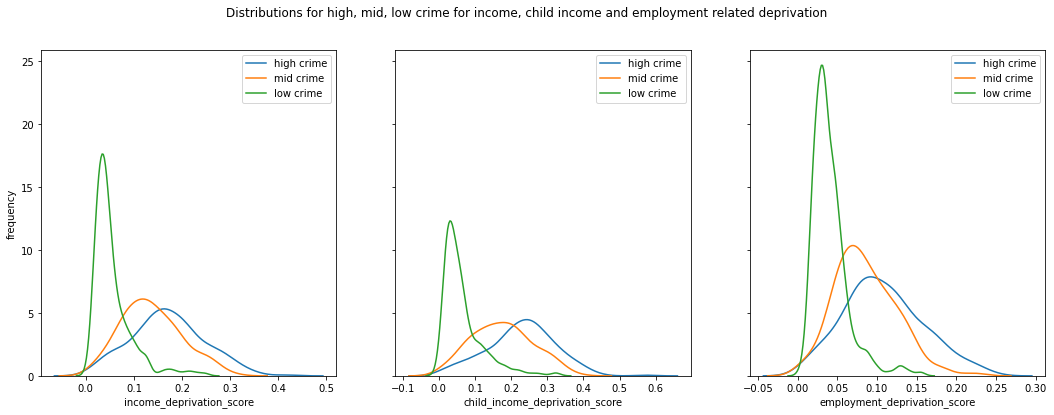

In [19]:
cohort_size = 250
all_cohorts_250 = display_cohort(violence_deprivation, 'crime_per_1000', cohort_size)

### cohort size = 500


Top 500 proportion = 27.78%, middle 500 proportion = 7.88%, bottom 500 proportion = 2.63% 

cohort shape
(1500, 15)


<Figure size 360x360 with 0 Axes>

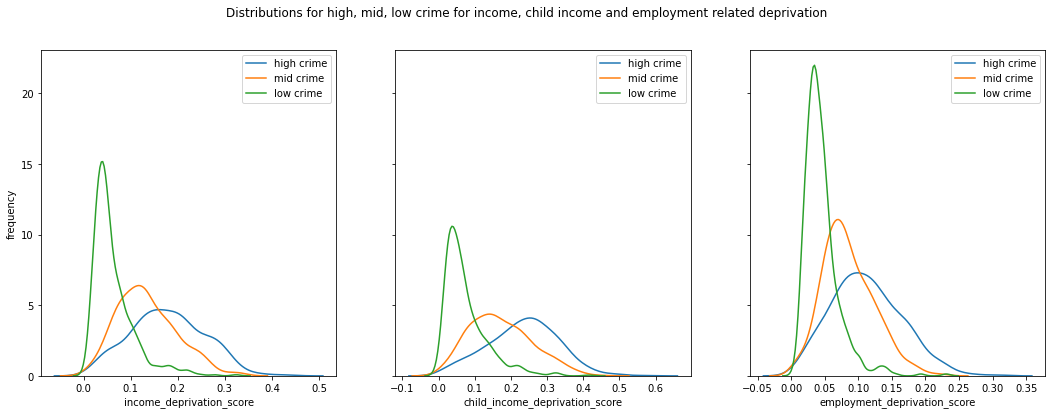

In [20]:
cohort_size = 500
all_cohorts_500 = display_cohort(violence_deprivation, 'crime_per_1000', cohort_size)

### Cohen's D
Now calculate and report Cohen's D:
- For each cohort size: all_cohorts_250, all_cohorts_500
- Between high and mid, high and low, mid and low

When assessing effect size, we use the following convention:

- Small Effect Size: d=0.20
- Medium Effect Size: d=0.50
- Large Effect Size: d=0.80

We will also use 2 standard deviations for confidence interval, meaning we have a 95% confidence that the Cohen's D will fall between its upper and lower interval values

In [103]:
# create our dataframe to store results
cohens_d_results = pd.DataFrame(columns=['description',
                                         'effect_size',
                                         'cohens_lower',
                                         'cohens_upper']) 

# all_cohorts_250
num_stds = 2
sample_size = 250

all_cohorts = all_cohorts_250
all_cohorts_high = all_cohorts[all_cohorts.crime_cohort == 'high']
all_cohorts_mid = all_cohorts[all_cohorts.crime_cohort == 'mid']
all_cohorts_low = all_cohorts[all_cohorts.crime_cohort == 'low']

cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_high.income_deprivation_score,
                                              all_cohorts_mid.income_deprivation_score, num_stds, 
                                              'income(250): high vs mid', sample_size), ignore_index=True)
cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_high.income_deprivation_score,
                                              all_cohorts_low.income_deprivation_score, num_stds, 
                                              'income(250): high vs low', sample_size), ignore_index=True)
cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_mid.income_deprivation_score,
                                              all_cohorts_low.income_deprivation_score, num_stds, 
                                              'income(250): mid vs low', sample_size), ignore_index=True)
cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_high.child_income_deprivation_score,
                                              all_cohorts_mid.child_income_deprivation_score, num_stds, 
                                              'child income(250): high vs mid', sample_size), ignore_index=True)
cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_high.child_income_deprivation_score,
                                              all_cohorts_low.child_income_deprivation_score, num_stds, 
                                              'child income(250): high vs low', sample_size), ignore_index=True)
cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_mid.child_income_deprivation_score,
                                              all_cohorts_low.child_income_deprivation_score, num_stds, 
                                              'child income(250): mid vs low', sample_size), ignore_index=True)
cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_high.employment_deprivation_score,
                                              all_cohorts_mid.employment_deprivation_score, num_stds, 
                                              'employment(250): high vs mid', sample_size), ignore_index=True)
cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_high.employment_deprivation_score,
                                              all_cohorts_low.employment_deprivation_score, num_stds, 
                                              'employment(250): high vs low', sample_size), ignore_index=True)
cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_mid.employment_deprivation_score,
                                              all_cohorts_low.employment_deprivation_score, num_stds, 
                                              'employment(250): mid vs low', sample_size), ignore_index=True)

# all_cohorts_500
num_stds = 2
sample_size = 500

all_cohorts = all_cohorts_500
all_cohorts_high = all_cohorts[all_cohorts.crime_cohort == 'high']
all_cohorts_mid = all_cohorts[all_cohorts.crime_cohort == 'mid']
all_cohorts_low = all_cohorts[all_cohorts.crime_cohort == 'low']

cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_high.income_deprivation_score,
                                              all_cohorts_mid.income_deprivation_score, num_stds, 
                                              'income(500): high vs mid', sample_size), ignore_index=True)
cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_high.income_deprivation_score,
                                              all_cohorts_low.income_deprivation_score, num_stds, 
                                              'income(500): high vs low', sample_size), ignore_index=True)
cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_mid.income_deprivation_score,
                                              all_cohorts_low.income_deprivation_score, num_stds, 
                                              'income(500): mid vs low', sample_size), ignore_index=True)
cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_high.child_income_deprivation_score,
                                              all_cohorts_mid.child_income_deprivation_score, num_stds, 
                                              'child income(500): high vs mid', sample_size), ignore_index=True)
cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_high.child_income_deprivation_score,
                                              all_cohorts_low.child_income_deprivation_score, num_stds, 
                                              'child income(500): high vs low', sample_size), ignore_index=True)
cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_mid.child_income_deprivation_score,
                                              all_cohorts_low.child_income_deprivation_score, num_stds, 
                                              'child income(500): mid vs low', sample_size), ignore_index=True)
cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_high.employment_deprivation_score,
                                              all_cohorts_mid.employment_deprivation_score, num_stds, 
                                              'employment(500): high vs mid', sample_size), ignore_index=True)
cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_high.employment_deprivation_score,
                                              all_cohorts_low.employment_deprivation_score, num_stds, 
                                              'employment(500): high vs low', sample_size), ignore_index=True)
cohens_d_results = cohens_d_results.append(cohens_d(all_cohorts_mid.employment_deprivation_score,
                                              all_cohorts_low.employment_deprivation_score, num_stds, 
                                              'employment(500): mid vs low', sample_size), ignore_index=True)

In [104]:
cohens_d_tidy = pd.melt(cohens_d_results, id_vars=['description'], 
                        value_vars=['effect_size', 
                                    'cohens_lower',
                                    'cohens_upper'], var_name = 'measure', value_name='value')

In [105]:
measures_ = ["cohens_lower", "cohens_upper", "effect_size"]
measure_colours_ = ["rgb(211,211,211)", "rgb(211,211,211)", "rgb(69,69,69)"]
colours_obj_1 = alt.Color("measure:N", scale=alt.Scale(domain=measures_, range=measure_colours_), legend=None)

alt.Chart(cohens_d_tidy, title='Cohens D: Effect Size and Confidence Intervals').mark_circle(size=100).encode(
    x=alt.X('value:Q', axis=alt.Axis(title='value', ticks=False,values=[0, 0.5, 1.0, 1.5, 2.0, 2.5])),
    y=alt.Y('description:N', axis=alt.Axis(title=None, ticks=False), sort='-x'),
    color=colours_obj_1,
    tooltip=['value']
).configure_axis(
    grid=False,
    domain=False
).configure_view(
    strokeWidth=0).interactive()


alt.Chart(...)

In [107]:
cohens_d_results.sort_values(by='effect_size', ascending=False)

description effect_size cohens_lower cohens_upper
4   child income(250): high vs low      2.1115       1.8883       2.3348
13  child income(500): high vs low      1.9826       1.8282       2.1371
1         income(250): high vs low      1.9192       1.7030       2.1354
10        income(500): high vs low      1.8231       1.6726       1.9736
7     employment(250): high vs low      1.7334       1.5236       1.9432
16    employment(500): high vs low      1.6339       1.4878       1.7800
2          income(250): mid vs low      1.5600       1.3557       1.7643
5    child income(250): mid vs low      1.5525       1.3484       1.7566
8      employment(250): mid vs low      1.4002       1.2006       1.5998
11         income(500): mid vs low      1.3198       1.1802       1.4594
14   child income(500): mid vs low      1.3168       1.1773       1.4563
17     employment(500): mid vs low      1.2200       1.0822       1.3577
12  child income(500): high vs mid      0.6771       0.5470       0.8072
9         income(500): high vs mid      0.6196       0.4901       0.7491
15    employment(500): high vs mid      0.5952       0.4660       0.7245
3   child income(250): high vs mid      0.5950       0.4122       0.7778
6     employment(250): high vs mid      0.5081       0.3263       0.6898
0         income(250): high vs mid      0.4971       0.3155       0.6788

## Conclusions
We calculated a confidence interval based on 2 standard deviations and so we have a 95% confidence that the effect size falls between the upper and lower cohens D limits.

What these results tell us is that there is a large effect size between mean levels of deprivation in areas with high crime and those with low serious violent crime and there is a medium effect size between areas with high and mid level serious violent crimes. *****

In [ ]:
# Use numpy to convert to arrays
import numpy as np
# Labels are the values we want to predict
labels = np.array(dataset['high_violence'])
# Remove the labels from the features
# axis 1 refers to the columns
dataset= dataset.drop('high_violence', axis = 1)
# Saving feature names for later use
feature_list = list(dataset.columns)
# Convert to numpy array
features = np.array(dataset)

In [ ]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from collections import Counter

In [ ]:
# using naive oversampling I get a dataset with 27404 = y and same number =n
#from imblearn.over_sampling import RandomOverSampler
#ros = RandomOverSampler(random_state=0)
#X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

from imblearn.over_sampling import SMOTE, ADASYN
X_resampled, y_resampled = SMOTE().fit_resample(train_features, train_labels)

y_resampled.shape, X_resampled.shape

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, oob_score = True,
                           bootstrap = True, random_state = 42)
# Train the model on training data
rf.fit(X_resampled, y_resampled);

print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_resampled, y_resampled), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(test_features, test_labels)))

In [ ]:
#dataset = vio_socio_injury[['pct_unemployed', 
#                               'pct_no_qualification', 
#                               'pct_no_cars', 
#                               'num_benefit_claimants',
#                               'mean_income',
#                               'median_income',
#                               'child_deprivation',
#                               'Education, Skills and Training Rank (where 1 is most deprived)',
#                               'Children and Young People Sub-domain Rank (where 1 is most deprived)',
#                               'Living Environment Rank (where 1 is most deprived)',
#                               'high_violence'
#                              ]].copy()

## random forests 
Stuff largely taken from 
https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

In [ ]:
# Use numpy to convert to arrays
import numpy as np
# Labels are the values we want to predict
labels = np.array(dataset['high_violence'])
# Remove the labels from the features
# axis 1 refers to the columns
dataset= dataset.drop('high_violence', axis = 1)
# Saving feature names for later use
feature_list = list(dataset.columns)
# Convert to numpy array
features = np.array(dataset)

In [ ]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [ ]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, oob_score = True,
                           bootstrap = True, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(train_features, train_labels), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(test_features, test_labels)))

### Comments
Well, there is some overfitting in the model, as it performs much worse on OOB sample and worse on the validation set.

In [ ]:
import time
import numpy as np

start_time = time.time()
importances = rf.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in rf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

In [ ]:
feature_list

In [ ]:
feature_names = [f'feature {i}' for i in range(features.shape[1])]

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Comments
It looks like features 2, 3, 6 and 9 have the biggest impact. These are: pct_no_cars, num_benefit_claimants, child_deprivation, Living Environment Rank.

So redo, using just these fields - 

what I found was that this increased recall but reduced precision. so try again

In [ ]:
dataset = vio_socio_injury[['pct_no_cars', 
                               'num_benefit_claimants',
                               'child_deprivation',
                               'Living Environment Rank (where 1 is most deprived)',
                               'high_violence'
                              ]].copy()

In [ ]:
# Labels are the values we want to predict
labels = np.array(dataset['high_violence'])
# Remove the labels from the features
# axis 1 refers to the columns
dataset= dataset.drop('high_violence', axis = 1)
# Saving feature names for later use
feature_list = list(dataset.columns)
# Convert to numpy array
features = np.array(dataset)

In [ ]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [ ]:
rf = RandomForestClassifier(n_estimators = 1000, oob_score = True,
                           bootstrap = True, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(train_features, train_labels), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(test_features, test_labels)))

In [ ]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    rf, test_features, test_labels, n_repeats=10, random_state=42, n_jobs=2)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

In [ ]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

### Comments
In this case we have bigger important for 0, 2, and 3 i.e. 'pct_unemployed', 'pct_no_cars', 'num_benefit_claimants' so lets try that

In [ ]:
dataset = vio_socio_injury[['pct_unemployed', 
                               'pct_no_cars',
                               'num_benefit_claimants',
                               'high_violence'
                              ]].copy()

In [ ]:
# Labels are the values we want to predict
labels = np.array(dataset['high_violence'])
# Remove the labels from the features
# axis 1 refers to the columns
dataset= dataset.drop('high_violence', axis = 1)
# Saving feature names for later use
feature_list = list(dataset.columns)
# Convert to numpy array
features = np.array(dataset)

In [ ]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [ ]:
rf = RandomForestClassifier(n_estimators = 1000, oob_score = True,
                           bootstrap = True, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(train_features, train_labels), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(test_features, test_labels)))

### Comments
This had crap results for everything so don't use

In [ ]:
# Calculate feature importances
importances = rf.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

indices

In [ ]:
feature_list = list(dataset.columns)

feature_list[0]

In [ ]:


# Rearrange feature names so they match the sorted feature importances
names = [feature_list[i] for i in indices]

# Barplot: Add bars
plt.bar(range(dataset.shape[1]), importances[indices])
# Add feature names as x-axis labels
plt.xticks(range(dataset.shape[1]), names, rotation=20, fontsize = 8)
# Create plot title
plt.title("Feature Importance")
# Show plot
plt.show()

In [ ]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
predictions[0:10]

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [ ]:
def RF_performance_reporting(y_pred, y_test, description, print_output=True):    
    # I now want to create a confusion matrix and to do this I first have to 
    # change my model output from a probability to a label 1 or 0
   
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
    
    if print_output:
        
        print('------------------------------------------------------------------')
        print('Printing performance metrics for ' + description)
        print('------------------------------------------------------------------\n')
        print('prediction accuracy', accuracy)
        print('precision', precision)
        print('recall', recall)
        print('Area under the curve score', roc_auc)   
        print('\n')  

        fpr, tpr, thresholds = roc_curve(y_test, y_pred)

        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve')
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
        plt.show()
    
        print('\n Confusion Matrix - numbers\n')
        print(cm)
        
    return accuracy, precision, recall, roc_auc, tn, fp, fn, tp

accuracy, precision, recall, roc_auc, tn, fp, fn, tp = RF_performance_reporting(predictions, test_labels, 'socio', print_output=True)

In [ ]:
dataset_1 = vio_socio_injury[['pct_unemployed', 
                               'pct_no_qualification', 
                               'pct_no_cars', 
                               'num_benefit_claimants',
                               'mean_income',
                               'median_income',
                               'child_deprivation',
                               'Education, Skills and Training Rank (where 1 is most deprived)',
                               'Children and Young People Sub-domain Rank (where 1 is most deprived)',
                               'Living Environment Rank (where 1 is most deprived)',
                               'log_total'
                              ]].copy()

In [ ]:
corr = dataset_1.corr()
plt.figure(figsize = (8,8))

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True,
    fmt=".2f"
)